In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import import_ipynb
from dataset import DataMushroom
import pandas as pd
import numpy as np
from PIL import Image
from torchvision import transforms
from torchvision.models import resnet18
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, random_split
from torchvision.transforms import ToTensor



In [13]:
# Загрузка данных
df = pd.read_csv('E:\jupyter\Грибы\metadata\FungiTastic-FewShot\FungiTastic-FewShot-Train.csv')
# Выбор входных параметров X
X = df[['habitat', 'substrate', 'elevation', 'landcover', 'biogeographicalRegion', 'observationID','filename']]
# Выбор выходных параметров y 
y = df[['kingdom', 'phylum', 'class','category_id']]
data = DataMushroom(X,y)
print(data)
# Создаем загрузчик данных
train_loader = DataLoader(data, batch_size=2, shuffle=True)

СУПЕР ОСНОВНОЙ X
                                                habitat  \
0     Mixed woodland (with coniferous and deciduous ...   
1                                                garden   
2                                                garden   
3                                                garden   
4                                                garden   
...                                                 ...   
7814                                 Deciduous woodland   
7815                                 Deciduous woodland   
7816                       Unmanaged deciduous woodland   
7817                                        salt meadow   
7818                                        salt meadow   

                       substrate  elevation  landcover biogeographicalRegion  \
0     dead wood (including bark)        0.0       16.0           continental   
1     dead wood (including bark)        0.0       17.0           continental   
2     dead wood (including bark)  

In [14]:
for c in train_loader:
    print(c['x_data'].shape)
    print(c['y_data'].shape)
    print(c['images_tensor'].shape)
    print('-'*50)


torch.Size([2, 5])
torch.Size([2, 4])
torch.Size([2, 10, 3, 224, 224])
--------------------------------------------------
torch.Size([2, 5])
torch.Size([2, 4])
torch.Size([2, 10, 3, 224, 224])
--------------------------------------------------
torch.Size([2, 5])
torch.Size([2, 4])
torch.Size([2, 10, 3, 224, 224])
--------------------------------------------------
torch.Size([2, 5])
torch.Size([2, 4])
torch.Size([2, 10, 3, 224, 224])
--------------------------------------------------
torch.Size([2, 5])
torch.Size([2, 4])
torch.Size([2, 10, 3, 224, 224])
--------------------------------------------------
torch.Size([2, 5])
torch.Size([2, 4])
torch.Size([2, 10, 3, 224, 224])
--------------------------------------------------
torch.Size([2, 5])
torch.Size([2, 4])
torch.Size([2, 10, 3, 224, 224])
--------------------------------------------------
torch.Size([2, 5])
torch.Size([2, 4])
torch.Size([2, 10, 3, 224, 224])
--------------------------------------------------
torch.Size([2, 5])
torch

KeyboardInterrupt: 

In [3]:
# for i,c in enumerate(train_loader):
#     print(f"X_data shape: {c['x_data'].shape}")
#     print(f"y_data shape: {c['y_data'].shape}")
#     print(f"img shape: {c['images_tensor'].shape}")
#     print('-'*50)

In [4]:
unique_counts = {}
for c in data:
    y = c['y_data']
    # Обрабатываем все столбцы
    for col in range(y.shape[0]):
        unique_vals = torch.unique(y[col])
        if col not in unique_counts:
            unique_counts[col] = set()
        unique_counts[col].update(unique_vals.tolist())
        
unique_counts[0], unique_counts[3] = unique_counts[3], unique_counts[0]
for col, vals in unique_counts.items():
    print(f"Столбец {col}: {len(vals)} уникальных значений")

Столбец 0: 33 уникальных значений
Столбец 1: 3 уникальных значений
Столбец 2: 11 уникальных значений
Столбец 3: 2427 уникальных значений


In [5]:

for col, vals in unique_counts.items():
    print(f"Столбец {col}: {len(vals)} уникальных значений")

Столбец 0: 33 уникальных значений
Столбец 1: 3 уникальных значений
Столбец 2: 11 уникальных значений
Столбец 3: 2427 уникальных значений


In [6]:
# Загружаем предобученную модель ResNet18
model = resnet18(pretrained=True)

# Удаляем все слои после layer4
model = nn.Sequential(*list(model.children())[:-2])

# Выводим структуру модели
print("Архитектура ResNet18:")
print(model)

# Замораживаем веса предобученной модели
for param in model.parameters():
    param.requires_grad = False


c:\Users\Артём\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Артём\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Архитектура ResNet18:
Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tr

In [7]:
# Сначала очищаем предыдущую модель
model = resnet18(pretrained=True)
model = nn.Sequential(*list(model.children())[:-2])
class CustomResNet(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.cnn = (
            base_model.cnn if isinstance(base_model, CustomResNet)
            else nn.Sequential(
                *list(base_model),
                nn.AdaptiveAvgPool2d((1, 1))
            )
        )
        
        self.attention = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.fc_after_attention = nn.Sequential(
            nn.Linear(513, 384),
            nn.ReLU(),
            nn.LayerNorm(384),
            nn.Dropout(0.3),
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.LayerNorm(256),
            nn.Linear(256, 512)
        )
        
        self.parameters_net = nn.Sequential(
            nn.Linear(5, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512)
        )
        
        self.final_layers = nn.Sequential(
            nn.Linear(512, 1024),
            nn.Linear(1024, 768),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 4)  # Выходной слой под формат [2193, 1, 1, 17]
        )

    def hierarchical_structure(self, parameter, img_feature):
        parameter = parameter.float()
        expanded_param = parameter[:img_feature.size(0), 0].unsqueeze(1)
        combined_features = torch.cat([img_feature, expanded_param], dim=1)
        return self.fc_after_attention(combined_features)

    def attention_function(self, attention_weights):
        batch_size, num_images, channels, height, width = attention_weights.size()
        attention_weights = attention_weights.view(batch_size * num_images, channels, height, width)
        img_features = self.cnn(attention_weights)
        img_features = img_features.view(batch_size, -1, 512)
        attention_weights = self.attention(img_features)
        attention_weights = F.softmax(attention_weights, dim=1)
        weighted_features = attention_weights * img_features
        return weighted_features.sum(dim=1)

    def forward(self, img, parameters):
        if isinstance(img, list):
            img = torch.stack(img).unsqueeze(0)
        
        img_features = self.attention_function(img)
        atten = self.hierarchical_structure(parameters, img_features)
        
        # print(f'НОРМ {atten.shape}')
        # # Обработка через final_layers для получения нужного формата выхода
        # parameters_features = self.parameters_net(parameters)
        # print(f'СУПЕР ВАЖНО {parameters_features.shape}')
        # combined = torch.cat([atten, parameters_features], dim=1)
        output = self.final_layers(atten)
        
        return output

# Создаем экземпляр модели только один раз
model = CustomResNet(model)

print("\nОбновленная архитектура модели:")
print(model)




Обновленная архитектура модели:
CustomResNet(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [ ]:
class Custom(nn.Module):
    def __init__(self, base_model, unique_counts):
        super().__init__()
        self.unique_counts = unique_counts
        
        # GPU-optimized attention layers
        self.attention_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(513 + i, 256 + i),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256 + i, 513 + i)
            ).cuda() for i in range(5)
        ])

        # GPU-optimized CNN
        self.cnn = nn.Sequential(
            *list(base_model),
            nn.AdaptiveAvgPool2d((1, 1))
        ).cuda()
        
        # GPU-optimized attention
        self.attention = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
        ).cuda()
        
        # GPU-optimized output layer
        self.outlayer = nn.Sequential(
            nn.Linear(517, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.ReLU()
        ).cuda()

    def atteintion_img_patch(self, img_patch):
        img_patch = img_patch.cuda()
        batch, num_img, channels, width, height = img_patch.size()
        features_img = img_patch.view(batch*num_img, channels, width, height)
        features_img_cnn = self.cnn(features_img)
        
        prepared_features = features_img_cnn.view(batch, -1, 512)
        attention_feature = self.attention(prepared_features)
        attention_softmax = F.softmax(attention_feature, dim=1)
        
        attention_weight = prepared_features * attention_softmax
        return attention_weight.sum(dim=1)

    def additional_parameters(self, x_param, attention_img_features, i):
        if i == 5:
            return attention_img_features
        x_param = x_param.cuda()
        unification = torch.cat((attention_img_features, x_param.T[i].view(-1,1)), dim=1)
        attention_img_features = self.attention_layers[i](unification)
        if i < 4:
            hierarchy_output = nn.Linear(attention_img_features.size(1), len(self.unique_counts[i])).cuda()(attention_img_features)
            self.ouputs.append(hierarchy_output)
        return self.additional_parameters(x_param, attention_img_features, i+1)

    def forward(self, img_patch, parameters):
        self.ouputs = []
        attention_img = self.atteintion_img_patch(img_patch)
        reg = self.additional_parameters(parameters, attention_img, 0)
        x = self.outlayer(reg)
        return x, self.ouputs

resnet = resnet18(pretrained=True).cuda()
resnet = nn.Sequential(*list(resnet.children())[:-2])
model = Custom(resnet, unique_counts).cuda()

In [9]:
print(model)

Custom(
  (attention_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=513, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=256, out_features=513, bias=True)
      (4): Linear(in_features=513, out_features=513, bias=True)
    )
    (1): Sequential(
      (0): Linear(in_features=514, out_features=257, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=257, out_features=514, bias=True)
      (4): Linear(in_features=514, out_features=514, bias=True)
    )
    (2): Sequential(
      (0): Linear(in_features=515, out_features=258, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=258, out_features=515, bias=True)
      (4): Linear(in_features=515, out_features=515, bias=True)
    )
    (3): Sequential(
      (0): Linear(in_features=516, out_features=259, bias=True)
      (1): ReLU()
      (2): Dropout(p=

In [ ]:
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(10):
    running_loss = 0.0
    for d in train_loader:
        optimizer.zero_grad()
        img = d['images_tensor']
        x_data = d['x_data']
        y_data = d['y_data']

        output,ouputs = model(img, x_data)
        weights = [1/2427, 1/3, 1/11, 1/33]
        total_loss = 0
        for level in range(len(ouputs)):
            print('OUTPUT',ouputs[0])
            print('Y_DATA',y_data.T[level].long())
            loss = criterion(ouputs[level], y_data.T[level].long())
            loss.backward(retain_graph=True)
            # optimizer.step()
            total_loss += loss * weights[level]
        total_loss.backward()
        optimizer.step()
        print(total_loss.item())

torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([

KeyboardInterrupt: 

In [ ]:
opt = nn.CrossEntropyLoss()

In [39]:
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Изменяем выходной слой для 32 классов
model.outlayer = nn.Sequential(
    nn.Linear(517, 512),
    nn.ReLU(),
    nn.Linear(512, 2426)  # 32 класса
)

# Для графика
epoch_losses = []

for epoch in range(10):
    running_loss = 0.0
    for d in data:
        optimizer.zero_grad()
        img = d['images_tensor']
        x_data = d['x_data']
        y_data = d['y_data'].T[:,0][0].view(-1).long()
        
        # Проверка на корректность меток
        if y_data.max() >= 2426 or y_data.min() < 0:
            print(f"Пропуск батча с некорректными метками: {y_data}")
            continue
            
        output,ouputs = model(img, x_data)
        
        # Проверяем, есть ли правильный класс в топ-5 предсказаний
        top5 = output.topk(5)[1]
        if y_data in top5:
            loss = torch.tensor(0.0, device=output.device, requires_grad=True)  # Добавляем requires_grad
        else:
            loss = criterion(output, y_data)
            
        loss.backward()
        optimizer.step()
        
        loss_value = loss.item()
        print(f'y_data: {y_data[0].item()}, output: {output.argmax(1)[0].item()}, top5: {top5[0].tolist()}, loss: {loss_value}')
        epoch_losses.append(loss.detach())  # Сохраняем без градиентов
    # print(f'Epoch {epoch+1}, Avg Loss: {avg_loss}')


AttributeError: 'tuple' object has no attribute 'topk'

In [161]:
# Нормализуем потери через softmax
import torch.nn.functional as F
epoch_losses = torch.sigmoid(torch.tensor(epoch_losses)).tolist()


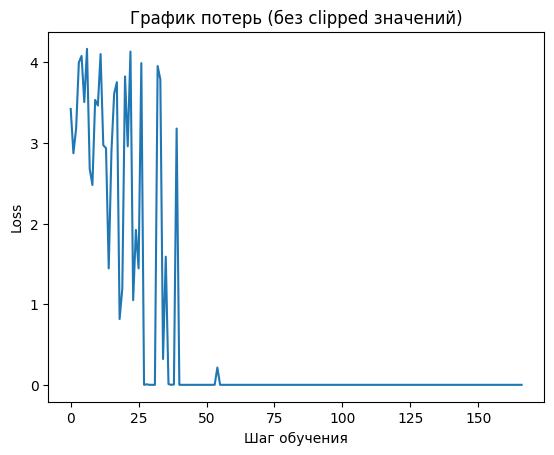

In [170]:
# Рисуем график, исключая loss = 5
import matplotlib.pyplot as plt
filtered_losses = [loss.detach().numpy() for loss in epoch_losses if loss.detach().numpy() < 5.0]
plt.plot(range(len(filtered_losses)), filtered_losses)
plt.xlabel('Шаг обучения')
plt.ylabel('Loss')
plt.title('График потерь (без clipped значений)')
plt.show()

In [48]:
# Определяем гиперпараметры
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10


Форма тензора: torch.Size([2, 2, 2])


In [49]:
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for d in data:
        x_train = d['x_data']
        img = d['images_tensor']
        y_data = d['y_data'][0].float().unsqueeze(0)  # Берем только первый экземпляр, преобразуем в float и добавляем размерность
        print(y_data)
        # Обнуляем градиенты
        optimizer.zero_grad()
        
        # Прямой проход
        outputs = model(img, x_train)
        
        # Вычисляем функцию потерь
        loss = criterion(outputs, y_data)
        
        # Обратное распространение
        loss.backward()
        
        # Оптимизация
        optimizer.step()
        
        running_loss += loss.item()
        print(running_loss)
    
    # Выводим среднюю потерю за эпоху
    epoch_loss = running_loss / len(data)
    print(f'Эпоха {epoch+1}/{num_epochs}, Потери: {epoch_loss:.4f}')

tensor([[2.4210e+03, 1.0000e+00, 1.0000e+00, 1.1000e+01]])
attention_weight_sum tensor([[0.9221, 0.9338, 0.9053, 0.9701, 0.9988, 0.8823, 0.8948, 1.1779, 0.9717,
         0.9679, 0.9024, 0.8307, 0.9903, 0.8833, 0.9465, 0.9499, 0.9226, 1.3537,
         0.9604, 0.8125, 0.8879, 1.0807, 0.9117, 1.0665, 0.8951, 0.9524, 0.9796,
         1.0217, 0.8870, 0.8555, 0.9506, 0.7839, 0.9691, 0.8803, 0.9253, 0.8467,
         0.9327, 0.9498, 0.8964, 0.9186, 0.8804, 0.9053, 0.8538, 0.9378, 0.8401,
         0.8704, 0.8906, 1.0982, 0.9733, 0.8903, 0.9285, 0.9045, 0.8441, 0.8155,
         0.9591, 0.9593, 1.1689, 0.8739, 0.9164, 1.0017, 0.8581, 0.9437, 0.9847,
         0.9815, 0.7418, 0.9707, 0.8157, 0.8546, 1.0004, 0.8961, 0.9282, 0.8297,
         0.9326, 0.8839, 0.9151, 0.8379, 0.9304, 0.8977, 0.9331, 0.8457, 0.9174,
         1.0339, 1.0753, 1.2782, 0.8392, 0.9522, 0.9563, 0.7447, 0.8987, 0.8243,
         0.8010, 0.9563, 0.8891, 0.8457, 0.8275, 0.8315, 0.9713, 0.9438, 0.8993,
         0.8661, 1.0673, 1.00

TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not NoneType

In [5]:
# Исходный тензор с формой (10, 3, 1, 1)
expanded_param = torch.randn(10, 3, 1, 1)

# Расширяем до (10, 3, 240, 240)
result = expanded_param.expand(-1, -1, 240, 240)

print("Исходная форма:", expanded_param)  # torch.Size([10, 3, 1, 1])
print("Новая форма:", result)    

Исходная форма: tensor([[[[ 1.1746]],

         [[-1.4089]],

         [[-0.3567]]],


        [[[-2.0994]],

         [[-0.5602]],

         [[-0.6238]]],


        [[[-0.7796]],

         [[ 1.3176]],

         [[ 0.4010]]],


        [[[ 0.3354]],

         [[ 0.9565]],

         [[-0.5290]]],


        [[[ 0.1972]],

         [[ 0.2292]],

         [[ 0.5302]]],


        [[[-0.3444]],

         [[-1.3209]],

         [[-1.1173]]],


        [[[-1.2505]],

         [[-0.2693]],

         [[-0.0982]]],


        [[[-0.8885]],

         [[-0.3858]],

         [[ 0.4821]]],


        [[[ 1.0204]],

         [[-0.0498]],

         [[-0.5802]]],


        [[[ 0.3428]],

         [[ 0.8945]],

         [[ 0.5881]]]])
Новая форма: tensor([[[[ 1.1746,  1.1746,  1.1746,  ...,  1.1746,  1.1746,  1.1746],
          [ 1.1746,  1.1746,  1.1746,  ...,  1.1746,  1.1746,  1.1746],
          [ 1.1746,  1.1746,  1.1746,  ...,  1.1746,  1.1746,  1.1746],
          ...,
          [ 1.1746,  1.1746,  1

0
1
2
3
